# Building a classifier from annotated data

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Setting up the environment

First we need to import the `linalgo` library to manipulate the tasks created online. The installation is described [here](https://linalgo.github.io/annotate-sdk/).

In [2]:
import os
from linalgo.hub.client import LinalgoClient

Then let's connect to the backend. 
- We need to know the address of you annotate instance (localhost in this case)
- To get the authentication token, we must connect to the platform and retrieve it from the developper dashboard

In [3]:
api_url = 'https://linapi.linalgo.com/hub'
linalgo_client = LinalgoClient(token=os.getenv('LINHUB_TOKEN'), api_url=api_url)

We are now ready to list the tasks to which we have access and select the ones we would like to work on.

In [4]:
task = linalgo_client.get_task('c91e77a8-85f0-4cd3-98e9-b9f2df62f36c', verbose=True)
print(task)

Retrivieving task with id c91e77a8-85f0-4cd3-98e9-b9f2df62f36c...
Retrieving annotators... (10 found)
Retrieving entities... (7 found)
Retrieving documents... (6478 found)
Retrieving annotations... (7894 found)
Task::c91e77a8-85f0-4cd3-98e9-b9f2df62f36c


## Training a machine learning algorithm

Let's look at the different types of annotations that have been made on the tasks we selected.

In [5]:
entities = task.entities
for entity in entities:
    print(entity)

Entity::CT Ideate
Entity::CT Justify
Entity::CT Validate
Entity::CT Challenge
Entity::CT Clarify
Entity::CT Synthesis
Entity::CT Elaboration


In this study, we're going to train one algorithm per entity type (binary classification). We'll start with the `CT Ideate` type (id 4) and filter the dataset for these annotations only using the `task_transform()` function. 

In [6]:
from linalgo.annotate.transformers import BinaryTransformer

entity = task.entities[0]
transformer = BinaryTransformer(pos_labels=[entity])
texts, labels = transformer.transform(task)

In [7]:
print(f"entity: {entity.name}")
print(f"number of docs: {len(texts)}")
print('----------------------------')
print(f"1: comment: '{texts[0]}', {entity.name}: {labels[0]}")
print(f"2: comment: '{texts[1]}', {entity.name}: {labels[1]}")
print(f"3: comment: '{texts[2]}', {entity.name}: {labels[2]}")
print('...')

entity: CT Ideate
number of docs: 1199
----------------------------
1: comment: 'Being filial in Asian communities is being welcome to their parents instead of rejecting them', CT Ideate: True
2: comment: 'That is a very weak and inaccurate way of stating what is filial piety.It might not even be about accepting your parents.It can be about other things like appreciating famliy traditions and cultures.Just saying that there is only one way of saying what is fillial piety is quite close minded in my opinion. Sincerely, Collin.', CT Ideate: True
3: comment: 'What do you mean by 'rejecting them'?', CT Ideate: False
...


We have 1199 documents and their associated labels for training. We can now use our favorite classifier from scikit-learn and fit it to our data.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.33, random_state=43)

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

text_clf.fit(X_train, y_train)
y_score = text_clf.decision_function(X_test)

## Evaluating the model

Now that we have a trained algorithm, we would like to know what kind of performance it has on our current dataset. We'll use the [AuROC](http://gim.unmc.edu/dxtests/roc3.htm) metric for that. [Other metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) might alos be appropriate depending on the type of task that we're automating. 

In [11]:
from sklearn.metrics import roc_curve, auc

In [12]:
fpr, tpr, thres = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

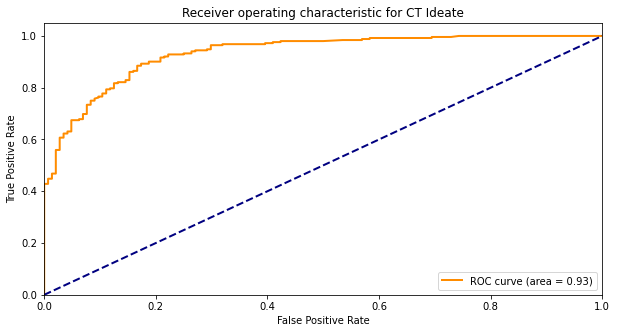

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Receiver operating characteristic for {entity.name}")
plt.legend(loc="lower right")
plt.show()